# Data Preprocessing

In [4]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
import os
import subprocess
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
import gc

import cv2
import torch

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Getting Face Tracks

In [5]:
from data_processing.face_tracks import get_single_face_tracks
from data_processing.video_utils import clip_video_ffmpeg

In [28]:
def crop_frame(frame, speaker):
	if speaker == "chem" or speaker == "hs":
		return frame
	elif speaker == "chess":
		H, W = frame.shape[:2]
		return frame[H//3:, W//2:]
		# return frame[270:460, 770:1130]
	elif speaker == "dl" or speaker == "eh":
		return  frame[int(frame.shape[0]*3/4):, int(frame.shape[1]*3/4): ]
	else:
		raise ValueError("Unknown speaker!")
		exit()

In [103]:
# video_path = './data/-0ZMU-gnm2g.mp4'
# video_path = './datasets/Lip2Wav/hs/videos/yzropgAwSI0.mp4'
# video_path = './datasets/Lip2Wav/hs/videos/0Twy4dNfLVM.mp4'
video_path = './datasets/Lip2Wav/chess/videos/KjZo4bLorsw.mp4'
frames = []
cap = cv2.VideoCapture(video_path)

while len(frames) < 2000:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = crop_frame(frame, 'chess')
    frames.append(frame)

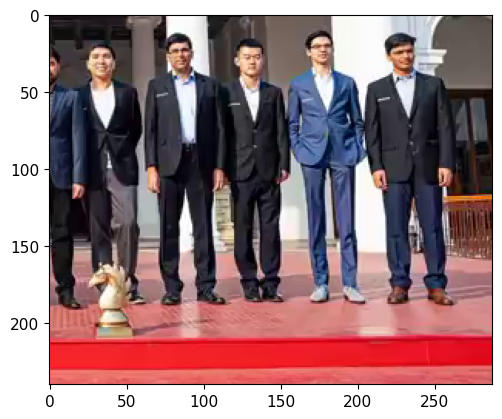

In [105]:
plt.imshow(frames[1990])
plt.show()

### Using MediaPipe

In [43]:
import mediapipe as mp

In [114]:
mp_face_detection = mp.solutions.face_detection
full_range_detector = mp_face_detection.FaceDetection(min_detection_confidence=0.5, model_selection=1)

print(mp_face_detection)
print(full_range_detector)

<module 'mediapipe.python.solutions.face_detection' from '/home/vanshg/anaconda3/envs/coursework/lib/python3.10/site-packages/mediapipe/python/solutions/face_detection.py'>


I0000 00:00:1721241717.494488   53285 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1721241717.544889   88307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce RTX 3050 6GB Laptop GPU/PCIe/SSE2


W0000 00:00:1721241717.557377   88304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [76]:
def get_bbox_from_mp_detection(detection):
    bboxC = detection.location_data.relative_bounding_box
    x1, y1 = bboxC.xmin * 1000, bboxC.ymin * 1000
    w, h = bboxC.width * 1000, bboxC.height * 1000
    x2, y2 = x1 + w, y1 + h

    bbox = (int(x1), int(y1), int(x2), int(y2))
    return bbox

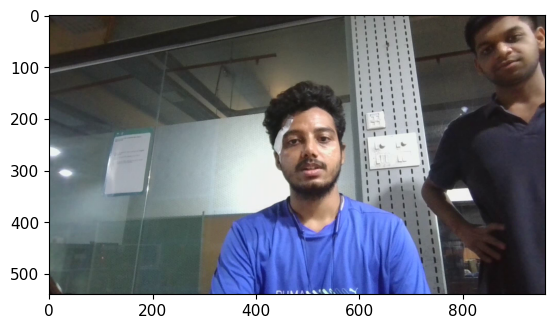

In [19]:
video_path = "./data/1.webm"

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.imshow(frame_rgb)

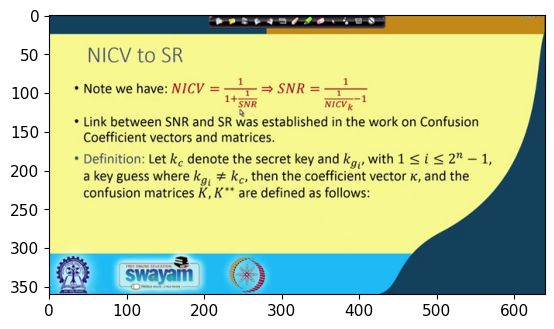

In [70]:
plt.imshow(frames[1700])
plt.show()

In [115]:
detector = full_range_detector
print(frames[87].shape)
results = full_range_detector.process(frames[275])
detected_faces = results.detections
bbox = get_bbox_from_mp_detection(detected_faces[0])
print(bbox)

(360, 640, 3)
(880, 728, 936, 828)


(360, 640, 3)


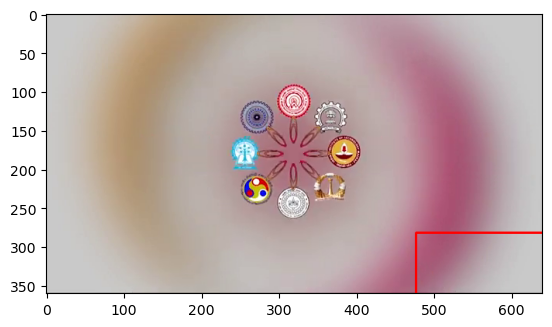

In [78]:
frame = copy.deepcopy(frames[87])
print(frame.shape)

(x1, y1, w, h) = bbox
cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), color=(255, 0, 0), thickness=2)

plt.imshow(frame)

### Using RetinaFace

In [58]:
from ibug.face_alignment import FANPredictor
from ibug.face_detection import RetinaFacePredictor

In [59]:
model_name = "resnet50"
face_detector = RetinaFacePredictor(device=device, threshold=0.8, model=RetinaFacePredictor.get_model(model_name))

print(face_detector)

[]


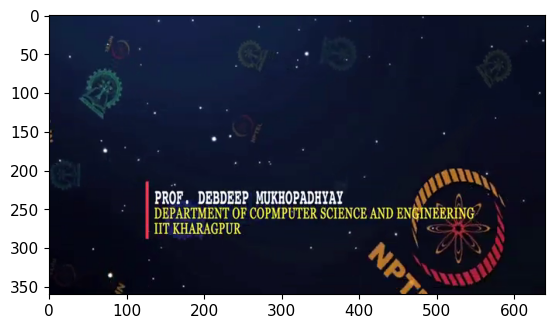

In [62]:
frame_idx = 254
detected_faces = face_detector(frames[frame_idx])
print(detected_faces)
plt.imshow(frames[frame_idx])
plt.show()

In [38]:
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(fps)

15


frames.shape = (128, 360, 640, 3)


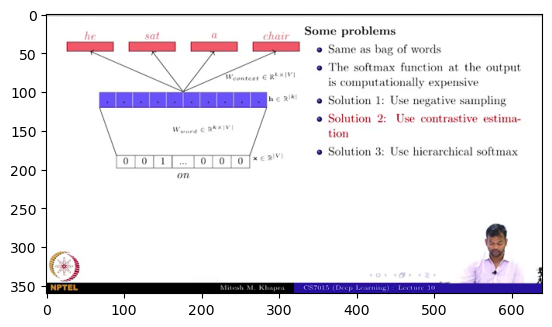

In [129]:
video_path = "./data/clip-1.mp4"

cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)

frames = np.array(frames)
print(f"{frames.shape = }")

plt.imshow(frames[0])
plt.show()

In [133]:
print(3/4 * 360)

270.0


(360, 640, 3)
(90, 160, 3)


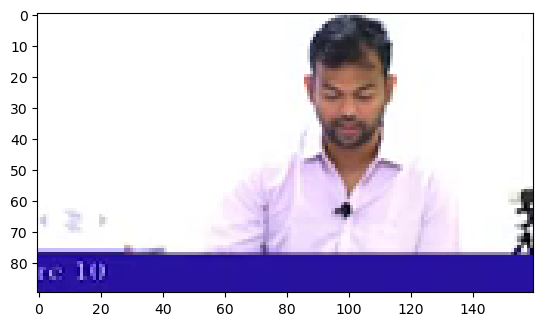

In [137]:
frame = frames[0]
print(frame.shape)
H, W = frame.shape[:2]
temp = frame[int(H * 3/4):, int(W * 3/4):, :]
print(temp.shape)
plt.imshow(temp)
plt.show()

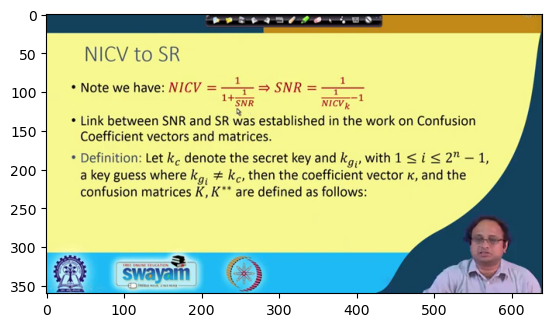

In [128]:
plt.imshow(frames[8])

In [51]:
# single_tracks = ["start_frame", "end_frame"]
tracks = []

for idx, frame in enumerate(frames):
    detected_faces = face_detector(frame, rgb=True)

    if len(detected_faces):
        detected_face = detected_faces[0]
        (x1, y1, x2, y2) = detected_face[:4]
        w, h = (x2 - x1), (y2 - y1)
        bbox = (x1, y1, w, h)

        if len(tracks):
            last_track = tracks[-1]
            last_track_frame = last_track['end_frame']
            if idx == last_track_frame + 1:
                last_track['end_frame'] = idx
                last_track['frames'].append(frame)
                last_track['bboxes'].append(bbox)
            else:
                print(f"New track started at frame idx: {idx}")
                new_track = {
                    "start_frame": idx,
                    "end_frame": idx,
                    "frames": [frame],
                    "bboxes": [bbox]
                }
                tracks.append(new_track)
        else:
            print(f"New track started at frame idx: {idx}")
            new_track = {
                "start_frame": idx,
                "end_frame": idx,
                "frames": [frame],
                "bboxes": [bbox]
            }
            tracks.append(new_track)


print(f"Total number of tracks = {len(tracks)}")

New track started at frame idx: 315
Total number of tracks = 1


In [8]:
tracks = get_single_face_tracks(frames, device)
print(f"Number of detected tracks = {len(tracks)}")

Processing Frames: 100%|██████████| 768/768 [00:18<00:00, 41.78it/s]

Number of detected tracks = 1


In [12]:
print(video_path)

./data/cut-0.mp4


In [19]:
track = tracks[0]
start_frame = track['start_frame']
end_frame = track['end_frame']
print(start_frame, end_frame)

fps = 15
start_time = int(start_frame/fps)
end_time = int(end_frame/fps) + 1

src_video_dir = os.path.dirname(video_path)

output_path = os.path.join(src_video_dir, "clip-1.mp4")

clip_video_ffmpeg(video_path, (start_time, end_time), output_path)

315 767


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


128


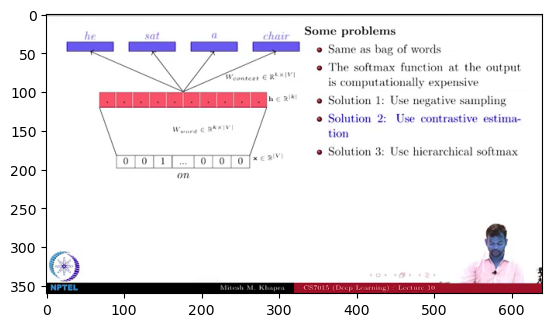

: 

In [22]:
new_vid_path = './data/clip-1.mp4'

new_frames = []
vid = cv2.VideoCapture(new_vid_path)

while vid.isOpened:
    ret, frame = vid.read()
    if not ret:
        break
    new_frames.append(frame)

print(len(new_frames))
plt.imshow(new_frames[0])

### Using Yolov5-face

In [91]:
def get_batch_prediction_yolov5(frames, face_detector):
     bboxes, points = face_detector.predict(frames)
     return bboxes

In [146]:
from preparation.detectors.yoloface.face_detector import YoloDetector

face_detector = YoloDetector(min_face=20)

cuda:0
/home/vanshg/play/IIITH/research-cvit/lip-reading/auto_avsr/preparation/detectors/yoloface/weights/yolov5n_state_dict.pt


In [93]:
bboxes = get_batch_prediction_yolov5(frames[10:20], face_detector)

In [96]:
print(len(bboxes))
print(bboxes)

10
[[], [], [], [], [], [], [], [], [], []]


[25, 20, 41, 40]


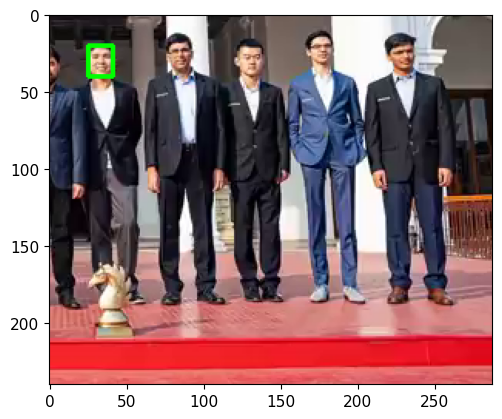

[[[25, 20, 41, 40], [0, 24, 4, 44]]]


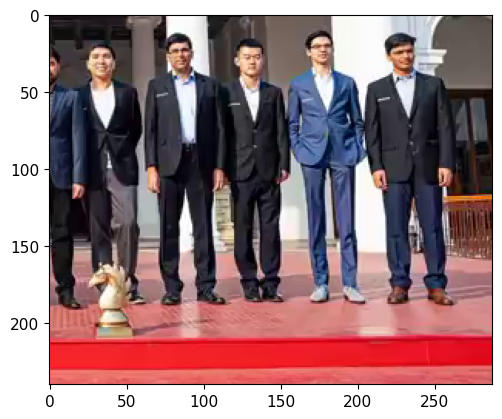

In [147]:
frame_idx = 1990
frame = frames[frame_idx]
# frame = cv2.cvtColor(cv2.imread('./agadmator.png'), cv2.COLOR_BGR2RGB)
H, W = frame.shape[:2]
temp = frame.copy()

bboxes, points = face_detector.predict(frame)
if len(bboxes[0]):
    bbox = bboxes[0][0]
    print(bbox)
    (x1, y1, x2, y2) = bbox
    cv2.rectangle(temp, (x1, y1), (x2, y2), (0, 255, 0), thickness=2)
    plt.imshow(temp)
    plt.show()

print(bboxes)
plt.imshow(frame)
plt.show()

### Using Face Alignment Network

In [40]:
frames = np.array(frames)
print(frames.shape)

(2000, 240, 288, 3)


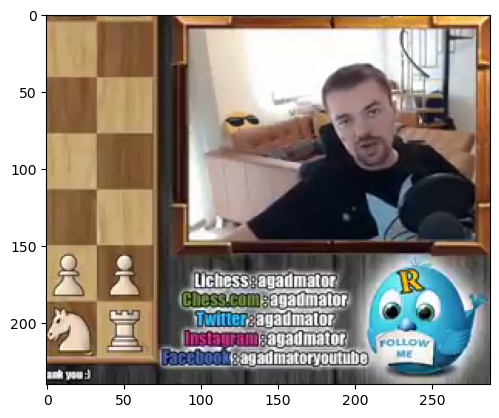

In [41]:
plt.imshow(frames[138])

In [11]:
import data_processing.face_detection as face_detection
face_detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, flip_input=False, device='cuda:0')

In [42]:
preds = face_detector.get_detections_for_batch(frames[1990:])

In [56]:
print(len(preds))
print(preds[0])

10
(array([[[ 72,  61,  58],
        [ 78,  67,  64],
        [103,  82,  82],
        [ 81,  60,  60],
        [ 82,  60,  63],
        [ 59,  37,  40],
        [ 32,  10,  15],
        [ 32,  10,  15],
        [ 30,  11,  15],
        [ 30,  11,  15],
        [ 25,  20,  19],
        [  0,   0,   0],
        [ 35,  33,  31],
        [ 68,  66,  64],
        [ 54,  49,  48]],

       [[ 80,  69,  66],
        [ 82,  71,  68],
        [ 73,  52,  52],
        [ 45,  24,  24],
        [ 72,  50,  53],
        [103,  81,  84],
        [103,  81,  86],
        [ 95,  73,  78],
        [ 78,  59,  63],
        [ 71,  52,  56],
        [ 36,  31,  30],
        [  5,   0,   0],
        [ 16,  14,  12],
        [ 21,  19,  17],
        [ 49,  44,  43]],

       [[ 89,  74,  63],
        [ 89,  74,  63],
        [ 72,  44,  33],
        [145, 117, 106],
        [216, 178, 170],
        [230, 192, 184],
        [223, 173, 167],
        [215, 165, 159],
        [201, 150, 140],
        [194, 143

## Getting transcripts from Whisper

In [7]:
import whisper

In [20]:
video_path = './data/LHL5SkYONjg.mp4'

model = whisper.load_model('small')
result = model.transcribe(video_path)

In [27]:
print(type(result))
print(result.keys())
segments = result['segments']

print(type(segments), len(segments))
print(segments[5])

<class 'dict'>
dict_keys(['text', 'segments', 'language'])
<class 'list'> 194
{'id': 5, 'seek': 2684, 'start': 26.84, 'end': 31.12, 'text': " he doesn't get to go into the playoffs. So people who go into the playoffs are", 'tokens': [50364, 415, 1177, 380, 483, 281, 352, 666, 264, 41142, 13, 407, 561, 567, 352, 666, 264, 41142, 366, 50578], 'temperature': 0.0, 'avg_logprob': -0.19469501591530167, 'compression_ratio': 1.8373983739837398, 'no_speech_prob': 0.21479617059230804}


In [31]:
audio = whisper.load_audio(video_path)
audio = whisper.pad_or_trim(audio)

mel = whisper.log_mel_spectrogram(audio).to(model.device)
options = whisper.DecodingOptions(language="en", without_timestamps=False, fp16=False)
result = whisper.decode(model, mel, options)

In [37]:
print(type(result))
print(result)

<class 'whisper.decoding.DecodingResult'>
DecodingResult(audio_features=tensor([[-0.1800, -0.6548,  1.1791,  ..., -0.3529, -0.3710, -0.1378],
        [ 0.9183,  1.4822,  1.7061,  ..., -0.5757,  0.4751,  0.0989],
        [ 0.4328,  0.9152,  1.8110,  ..., -0.8506, -0.1808, -0.3569],
        ...,
        [ 1.4128, -0.0374,  4.4076,  ..., -0.1171,  0.6438,  1.8401],
        [ 0.1561,  0.9463,  3.7649,  ...,  1.2838,  0.2154,  0.2719],
        [-1.2362,  0.9978,  2.7442,  ...,  0.2634, -1.2946,  0.5222]],
       device='cuda:0'), language='en', language_probs=None, tokens=[50364, 2425, 1518, 293, 2928, 646, 281, 264, 43560, 388, 391, 27014, 4808, 13, 467, 311, 472, 295, 264, 50626, 50626, 11255, 295, 264, 4808, 11255, 13713, 11, 8979, 39, 1459, 5717, 5080, 12, 5294, 12, 2641, 50838, 50838, 7220, 6757, 21640, 4389, 3457, 43108, 293, 934, 1266, 13757, 456, 311, 257, 731, 3407, 51110, 51110, 561, 7582, 337, 700, 1081, 457, 787, 1451, 4150, 352, 666, 7582, 9857, 11, 3620, 51396, 51396, 300, 290

## Getting Transcriptions for WhisperX

In [7]:
import whisperx

In [8]:
model_dir = "./checkpoints/whisperx"
device = 'cuda'
compute_type = "float16"
model = whisperx.load_model("large-v2", device, compute_type=compute_type)
# model = whisperx.load_model("large-v2", device, compute_type=compute_type, download_root=model_dir, language='en')

vocabulary.txt:   0%|          | 0.00/460k [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.80k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

RuntimeError: CUDA failed with error out of memory